In [ ]:
!pip install awpy
!pip install --force-reinstall "numpy[all]>=1.26.0,<2.2.0"
!pip install torch_geometric

In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings("ignore")

from awpy import Demo
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split

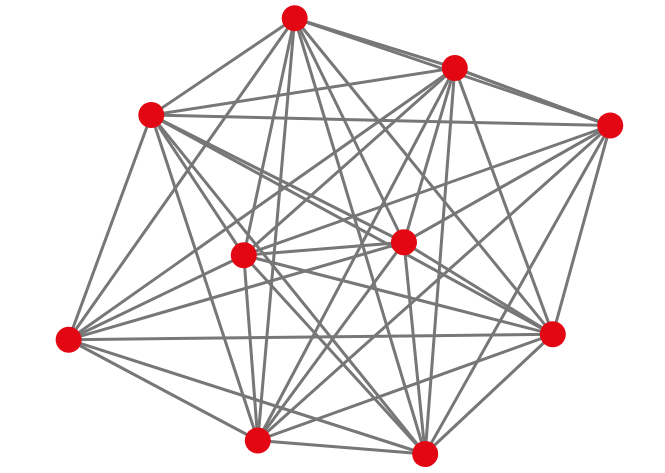

In [2]:
files = os.listdir('games')
df = pd.DataFrame()
list_dfs = []
for file in files:
    try:
        dem = Demo(f"games/{file}", verbose=True,tickrate=128)
    
        dem.parse(player_props=["X","Y","Z","health","inventory","has_helmet","has_defuser","side","current_equip_value","round_start_equip_value","armor_value","score","is_bomb_planted","is_alive","team_num","is_defusing","in_bomb_zone"])
        df_temp = dem.ticks.to_pandas()
        df_temp = df_temp.loc[df_temp["tick"]%128 == 0] 
        list_dfs.append(df_temp)
    except:
        print(file)
df = pd.concat(list_dfs, ignore_index=True)


2025-06-08 22:08:45.373 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/vitality-vs-the-mongolz-m3-mirage.dem


: 

In [1]:
"""
    High Explosive Grenade - he,
    Smoke Grenade - smoke,
    Molotov - molotov,
    Incendiary Grenade - incendiary,
    Decoy Grenade - decoy,
    Flashbang - flash
"""

df['he'] = df['inventory'].apply(lambda x: 1 if 'High Explosive Grenade' in x else 0)
df['smoke'] = df['inventory'].apply(lambda x: 1 if 'Smoke Grenade' in x else 0)
df['molotov'] = df['inventory'].apply(lambda x: 1 if 'Smoke Molotov' in x else 0)
df['incendiary'] = df['inventory'].apply(lambda x: 1 if 'Incendiary Grenade' in x else 0)
df['flash'] = df['inventory'].apply(lambda x: 1 if 'Flashbang' in x else 0)
df['decoy'] = df['inventory'].apply(lambda x: 1 if 'Decoy Grenade' in x else 0)
df.drop(columns=['inventory'],inplace=True)
df

NameError: name 'df' is not defined

In [151]:
players = sorted(df.steamid.unique())
ct_spawn = np.array([-1516.3, -1335.9, -259.97])   # CT Spawn
t_spawn  = np.array([1414.7,    27.6,  -167.97])   # T Spawn
site_a   = np.array([-580.9,  -2159.5, -179.97])   # Bombsite A
site_b   = np.array([-1700.0,   500.0, -230.0])    # Bombsite B 
graph_data_list = []

round_winner = dem.rounds['winner'].to_pandas()
round_winner = (round_winner.values == 'ct').astype(int) # CT = 1 | T = 0

for i,tick in enumerate(sorted(df.tick.unique())):
    state = df.loc[df['tick']==tick].set_index('steamid').loc[players]
    node_features = []
    for _, row in state.iterrows():
        pos = np.array([row['X'], row['Y'], row['Z']])
        dist_a = np.linalg.norm(pos - site_a)
        dist_b = np.linalg.norm(pos - site_b)
        feats = [
            row['X'], row['Y'], row['Z'],
            row['health'], row['armor'],
            row['current_equip_value'], row['round_start_equip_value'],
            row['he'], row['smoke'],row['flash'],row['molotov'],row['incendiary'],row['decoy'],
            dist_a, dist_b,
            int(row['in_bomb_zone']),
            int(row['is_alive']),
            int(row['has_helmet']),
            int(row['has_defuser']),
            1 if row['side'] == 'CT' else 0
        ]
        node_features.append(feats)

    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor([[i, j] for i in range(10) for j in range(10)], dtype=torch.long).t().contiguous()
    round_index = min(i, len(round_winner) - 1)
    y = torch.tensor(round_winner[round_index], dtype=torch.float)  # tira os colchetes []

    graph_data = Data(x=x, edge_index=edge_index, y=y)
    graph_data.num_nodes = x.shape[0]
    graph_data_list.append(graph_data)

print("Total Graphs: ", len(graph_data_list))
print("Players per Graph: ", 10)
print("Node Feature Size: ", x.shape[1])
print("y por grafo:", y.shape, y)

Total Graphs:  1090
Players per Graph:  10
Node Feature Size:  20
y por grafo: torch.Size([]) tensor(0.)


In [153]:
train_val_graphs, test_graphs = train_test_split(graph_data_list, test_size=0.2, random_state=42)
train_graphs, val_graphs = train_test_split(train_val_graphs, test_size=0.125, random_state=42)

In [154]:
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)

In [ ]:


class CSGOGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=1)
        self.gat2 = GATConv(hidden_channels, out_channels, heads=1)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)


In [160]:
model = CSGOGAT(in_channels=20, hidden_channels=16, out_channels=30)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

TypeError: Sigmoid.__init__() takes 1 positional argument but 2 were given

In [ ]:
from sklearn.metrics import roc_auc_score

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch).view(-1)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            out = model(batch).view(-1)
            loss = criterion(out, batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(out)
            all_preds.extend(probs.tolist())
            all_labels.extend(batch.y.tolist())
            break
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(loader.dataset), auc


In [162]:
results = []
for epoch in range(1, 100):
    train_loss = train()
    val_loss, val_auc = evaluate(val_loader)
    results.append((epoch, train_loss, val_loss, val_auc))

results_df = pd.DataFrame(results, columns=["Epoch", "Train Loss", "Val Loss", "Val AUC"])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
----
[2.78177315233008e-26, 7.285184891118504e-24, 1.116844420493394e-24, 0.0, 1.8829026664624828e-26, 2.920480128363212e-35, 3.4622643267135024e-33, 0.27674832940101624, 3.1757675974283765e-35, 9.872250217313194e-08, 1.6302786330650284e-29, 2.430795720834107e-36, 0.0, 3.1757675974283765e-35, 3.250858647215822e-33, 0.0, 0.08758050948381424, 7.34033936348448e-23, 0.0875750184059143, 8.279606382161102e-24, 2.3263826896558745e-30, 1.0039993281196757e-09, 1.2009164720439003e-06, 0.0002531532372813672, 2.8461686356643407e-32, 0.08763203769922256, 1.0217744540702312e-24, 0.08757837861776352, 8.157458392914439e-33, 4.490996744308678e-16, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
----
[1.9948362049011926e-25,

In [163]:
results_df

,Epoch,Train Loss,Val Loss,Val AUC
0,1,0.039912,6.338730e-03,NaN
1,2,0.049776,5.474856e-04,NaN
2,3,0.063996,2.259639e-04,NaN
3,4,0.050675,9.295809e-04,NaN
4,5,0.046365,2.634580e-02,NaN
...,...,...,...,...
94,95,0.081676,1.075117e-03,NaN
95,96,0.048208,1.454135e-05,NaN
96,97,0.040910,2.633541e-06,NaN
97,98,0.056343,3.095504e-05,NaN


In [ ]:
import torch
from torch.optim import Adam
from torch_geometric.loader import DataLoader

model = CSGO_GAT(in_feats=FEATURE_SIZE, hidden_feats=64, hidden_feats2=32)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs, batch_size=32)

for epoch in range(1, 51):  # e.g. train for 50 epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)            # forward pass (logits)
        loss = criterion(out.view(-1), batch.y)  # batch.y is shape [batch_size]
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    preds, truths = [], []
    for batch in val_loader:
        with torch.no_grad():
            out = model(batch)
            val_loss += criterion(out.view(-1), batch.y).item() * batch.num_graphs
            # collect predictions for AUC
            prob = torch.sigmoid(out.view(-1))
            preds.extend(prob.tolist())
            truths.extend(batch.y.tolist())
    val_loss /= len(val_loader.dataset)
    # Compute AUC on validation
    val_auc = compute_auc(truths, preds)  # use sklearn.metrics.roc_auc_score
    print(f"Epoch {epoch}: Train loss {avg_loss:.4f} | Val loss {val_loss:.4f} | Val AUC {val_auc:.4f}")


CT win rate: 0.009174311926605505
